In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load Json file, convert it into a DataFrame
logins = pd.read_json('logins.json')
logins = pd.DataFrame.from_dict(logins, orient= 'columns')

print(logins.shape)
logins.head()

(93142, 1)


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
#Sort the login_time ascending
logins = logins.sort_values(by= 'login_time', ascending='True')

In [4]:
logins.isna().sum()

login_time    0
dtype: int64

In [5]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-04-04 01:17:40
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


**Data is available for Jan, Feb, March and 13 days in April in 1970.**

# Part 1 - Exploratory Data Analysis

In [6]:
import datetime as dt
from datetime import datetime


#date
logins['date'] = logins['login_time'].apply(lambda x: pd.to_datetime(x.date()))
logins['year'] = logins['login_time'].apply(lambda x: x.year)
logins['month'] = logins['date'].apply(lambda x: x.month)
logins['day'] = logins['date'].apply(lambda x: x.day)



#weekday
logins['weekday'] = logins['date'].apply(lambda x: x.weekday())
day_name= ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
logins['weekday']= logins['weekday'].apply(lambda x: day_name[x])



#time
logins['time'] = logins['login_time'].apply(lambda x: x.time())
logins['hour'] = logins['time'].apply(lambda x: x.hour)
logins['min'] = logins['time'].apply(lambda x: x.minute)
logins['min'] = logins['min'].apply(lambda x: int(int(x)/15)*15)



#define intervals
logins['time'] = pd.to_datetime(logins['time'], format='%H:%M:%S').dt.time
logins['seconds'] = logins['time']\
        .apply(lambda x: int(dt.timedelta(hours= x.hour, minutes= x.minute, seconds= x.second).total_seconds()))
logins['interval'] = logins['seconds'].apply(lambda x: int(x/(15*60))+1)




#Create the interval start for each row
logins['start_intrval'] = logins[['year','month','day','hour', 'min']]\
                            .apply(lambda x : datetime(year=x[0], month=int(x[1]),day=x[2],hour= x[3],minute=x[4]), axis=1)



#parts of day
logins['parts_of_day'] = logins['time'].apply(lambda x: int(x.hour/6)+ 1 )
logins['parts_of_day']= logins['parts_of_day'].replace({1:'Night' , 2:'Morning' , 3: 'Afternoon' , 4: 'Evening'})


logins = logins[['start_intrval', 'interval', 'weekday','parts_of_day','login_time','date', 'year', 'month', 'day'\
                 ,'time', 'hour', 'min', 'seconds']]
print(logins.shape)
logins.head()

(93142, 13)


,start_intrval,interval,weekday,parts_of_day,login_time,date,year,month,day,time,hour,min,seconds
6,1970-01-01 20:00:00,81,Thu,Evening,1970-01-01 20:12:16,1970-01-01,1970,1,1,20:12:16,20,0,72736
0,1970-01-01 20:00:00,81,Thu,Evening,1970-01-01 20:13:18,1970-01-01,1970,1,1,20:13:18,20,0,72798
1,1970-01-01 20:15:00,82,Thu,Evening,1970-01-01 20:16:10,1970-01-01,1970,1,1,20:16:10,20,15,72970
3,1970-01-01 20:15:00,82,Thu,Evening,1970-01-01 20:16:36,1970-01-01,1970,1,1,20:16:36,20,15,72996
2,1970-01-01 20:15:00,82,Thu,Evening,1970-01-01 20:16:37,1970-01-01,1970,1,1,20:16:37,20,15,72997


In [7]:
demand_Jan = logins[logins.month == 1]
demand_Feb = logins[logins.month == 2]
demand_Mar = logins[logins.month == 3]
demand_Apr = logins[logins.month == 4]

In [8]:
import calendar

def demand_month(df, year, month):
    
    if month == 4:  #data in April is available for 13 days
        days_month = 13 
    else:    
        days_month = calendar.monthrange(year, month)[1]
    
    df = df.groupby(['parts_of_day','interval'])['interval'].count()/days_month
    df = pd.DataFrame(df)
    df = df.rename(columns= {'interval':'avg_demand'})
    df = df.reset_index()
    return df


In [9]:
def plot_avg_demand(df,month):
    
    plt.figure(figsize=(18,7))
    sns.scatterplot(x= df.interval , y= df.avg_demand, hue= df.parts_of_day)
    plt.title('Avg Demand per 15-minute Interval in {}'.format(month), fontsize=19, c='purple')
    plt.xticks(np.arange(0, 100, 4) ,np.arange(0, 25 , 1))
    plt.xlabel('')
    plt.ylabel('Avg Demand', fontsize=17, c='purple')
    plt.yticks(fontsize=13)
    plt.legend(fontsize=14)
    plt.show()

In [10]:
year= 1970
avg_demand_Jan = demand_month(demand_Jan, year, 1)
avg_demand_Feb = demand_month(demand_Feb, year, 2)
avg_demand_Mar = demand_month(demand_Mar, year, 3)
avg_demand_Apr = demand_month(demand_Apr, year, 4)

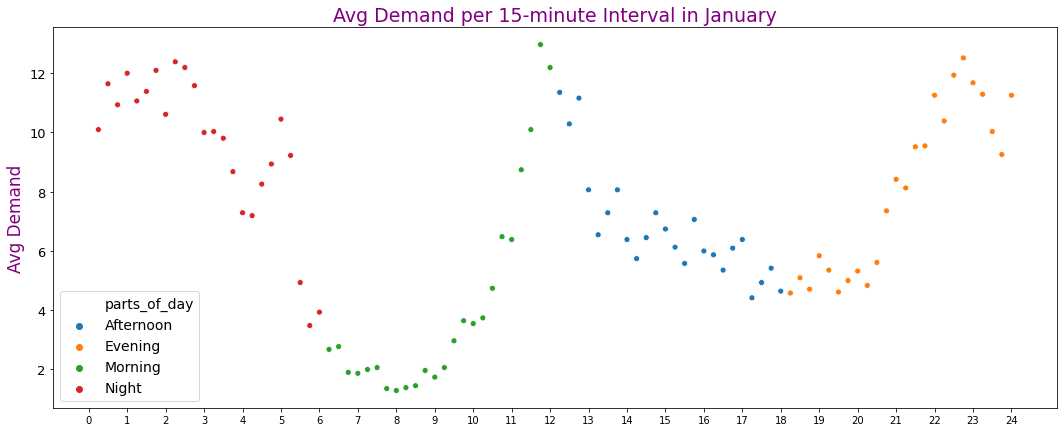

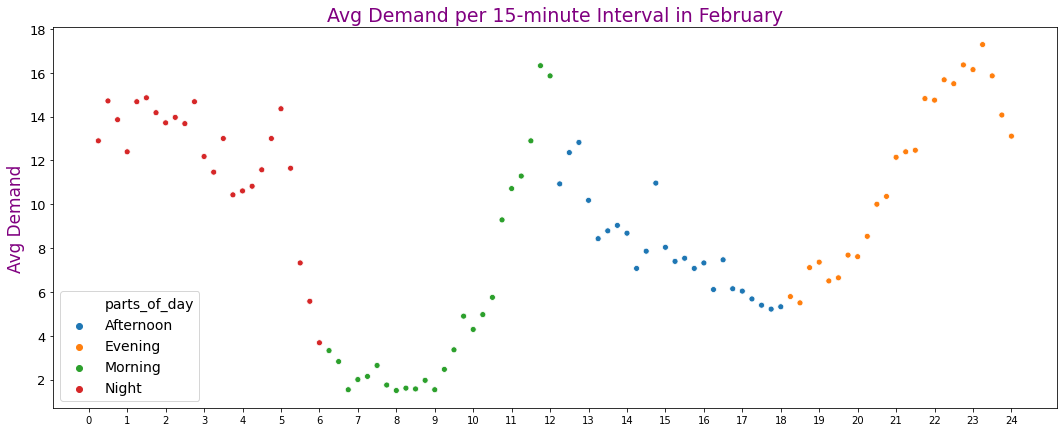

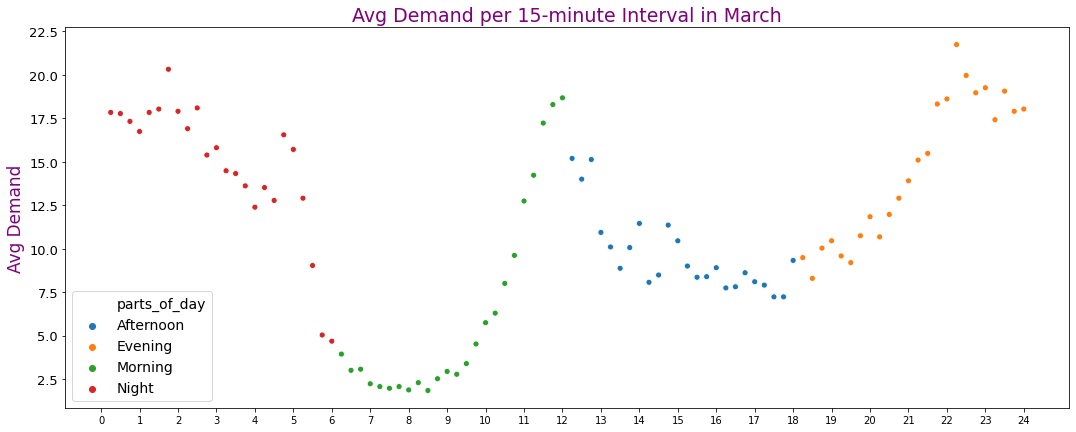

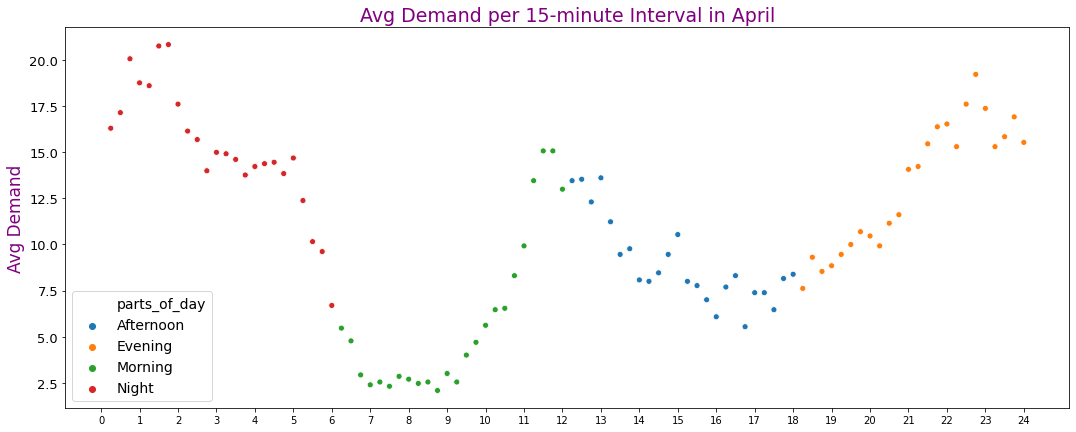

In [11]:
plot_avg_demand(avg_demand_Jan, 'January')
plot_avg_demand(avg_demand_Feb, 'February')
plot_avg_demand(avg_demand_Mar, 'March')
plot_avg_demand(avg_demand_Apr, 'April')

### Average demand per 15-minute intervals is dependent to the month and the time of the day.
* #### In general, level of demand in March is higher than the other 3 months.
* #### Demand around 2am, 12pm and 23 are at the highest level and between 7am and 9am are low.

### Demand in each interval is very close to demand in last two previous intervals.

In [12]:
diff = pd.Timedelta(logins.login_time.max() - logins.login_time.min() ,'D')

weeks_between = int(diff.days/7) 
weekday_count = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0 }
weekday_count = {key: val + weeks_between  for key, val in weekday_count.items()}


remaining_days = diff.days - (weeks_between * 7)
day_weeks_between_end =(logins.login_time.min() + dt.timedelta(weeks_between*7)).weekday()
for i in np.arange(1,remaining_days+1):
    weekday_count[day_weeks_between_end+i] += 1


weekday_count

{0: 14, 1: 14, 2: 14, 3: 14, 4: 15, 5: 15, 6: 15}

In [13]:
demand_Mon = logins[logins.weekday == 'Mon']
demand_Tue = logins[logins.weekday == 'Tue']
demand_Wed = logins[logins.weekday == 'Wed']
demand_Thu = logins[logins.weekday == 'Thu']
demand_Fri = logins[logins.weekday == 'Fri']
demand_Sat = logins[logins.weekday == 'Sat']
demand_Sun = logins[logins.weekday == 'Sun']

In [14]:
def demand_weekday(df, day):
    df = df.groupby(['parts_of_day', 'interval'])['interval'].count() / weekday_count[0]
    df = pd.DataFrame(df)

    df = df.rename(columns={'interval': 'avg_demand'})
    df = df.reset_index()
    return df

In [15]:
def plot_avg_demand(df, day):
    
    plt.figure(figsize=(18,7))
    sns.scatterplot(x= df.interval , y= df.avg_demand, hue= df.parts_of_day)
    plt.title('Avg Demand per 15-minute Interval on {}s'.format(day), fontsize=19, c='purple')
    plt.xticks(np.arange(0, 100, 4) ,np.arange(0, 25 , 1))
    plt.xlabel('')
    plt.ylabel('Avg Demand', fontsize=17)
    plt.yticks(fontsize=13, c='purple')
    plt.legend(fontsize=14)
    plt.show()

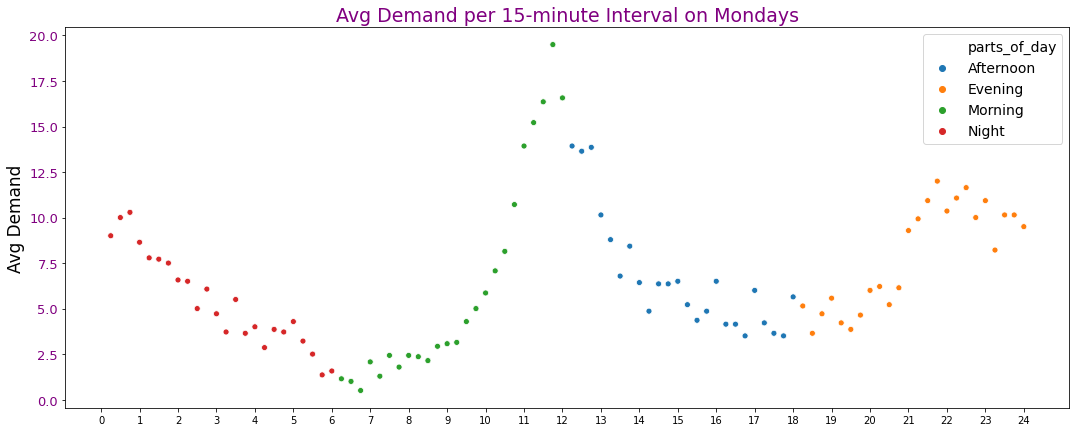

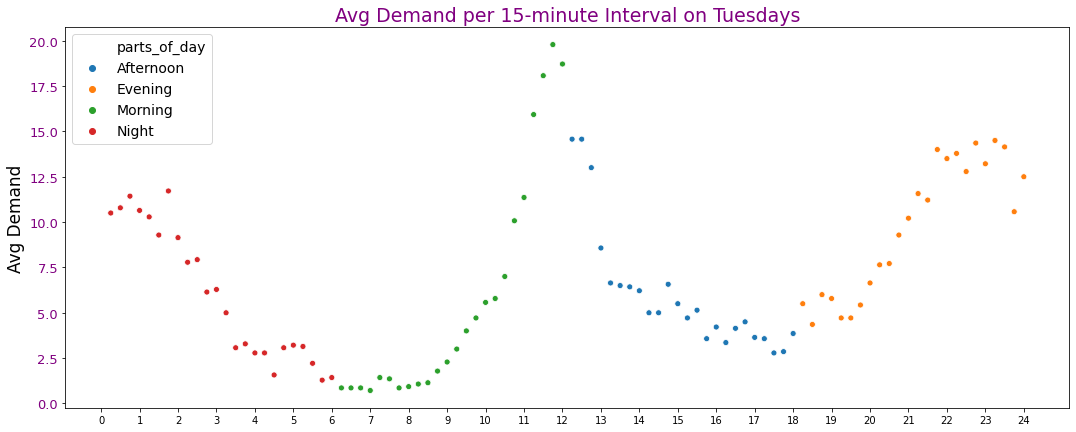

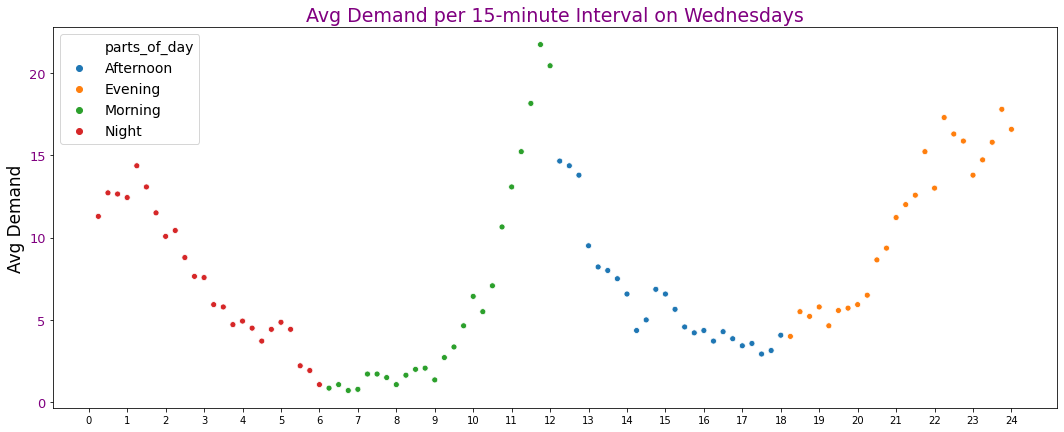

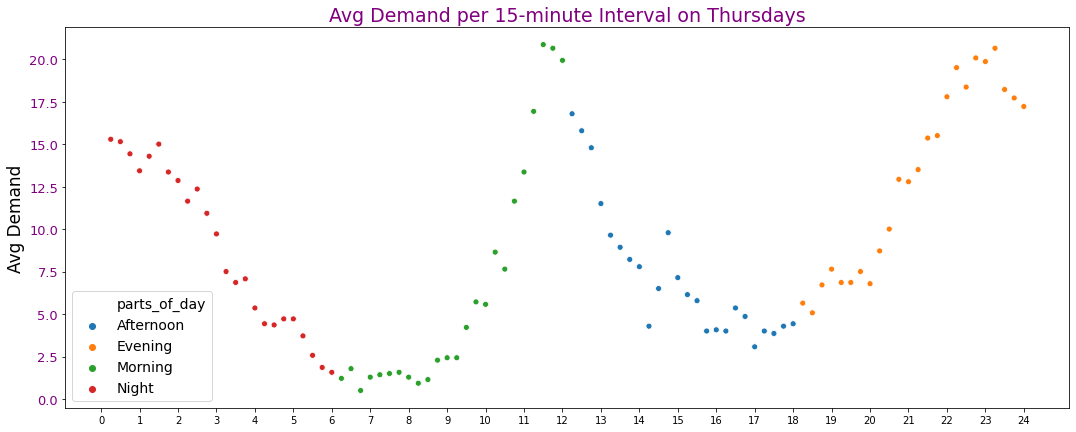

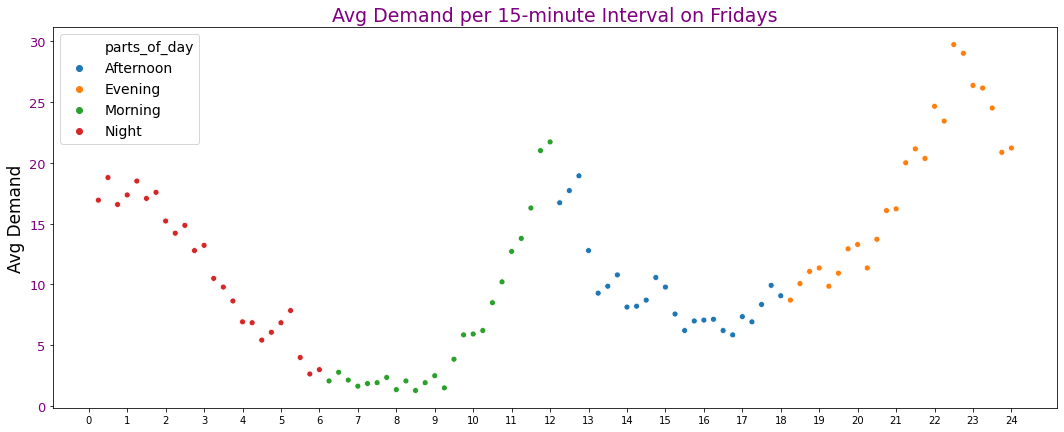

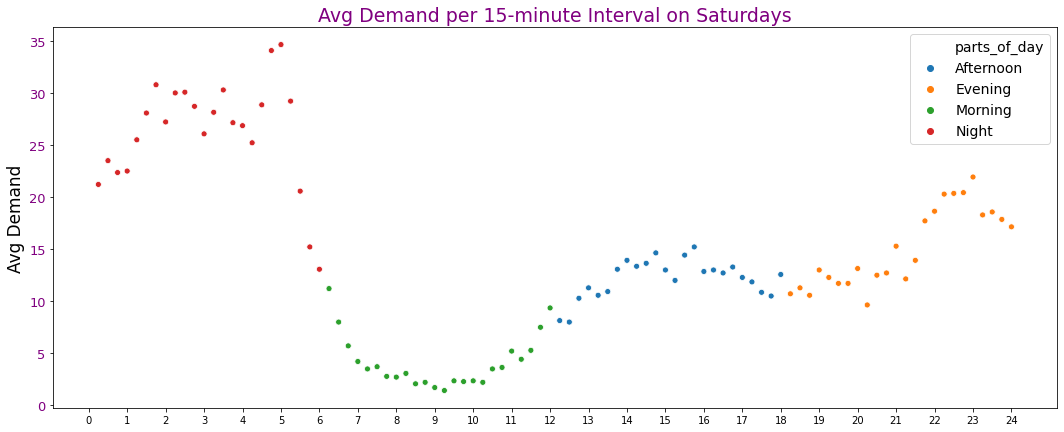

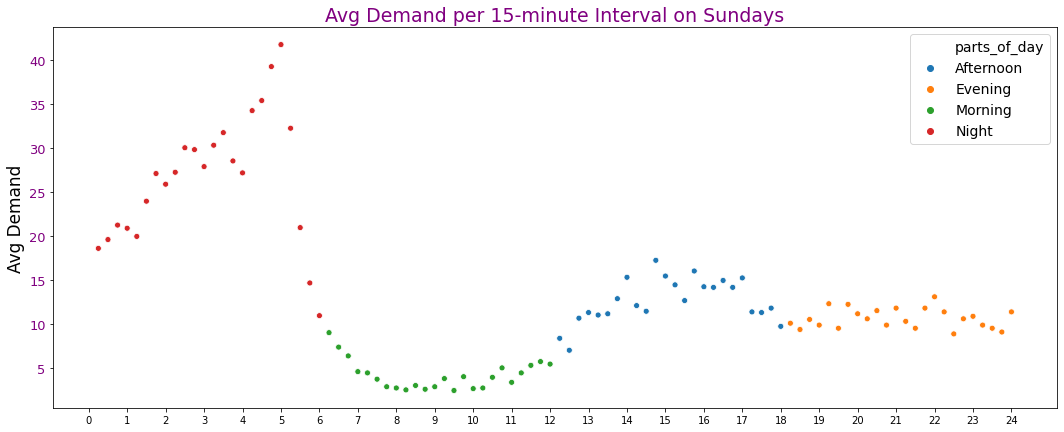

In [16]:
plot_avg_demand(demand_weekday(demand_Mon, 0), 'Monday')
plot_avg_demand(demand_weekday(demand_Tue, 1), 'Tuesday')
plot_avg_demand(demand_weekday(demand_Wed, 2), 'Wednesday')
plot_avg_demand(demand_weekday(demand_Thu, 3), 'Thursday')
plot_avg_demand(demand_weekday(demand_Fri, 4), 'Friday')
plot_avg_demand(demand_weekday(demand_Sat, 5), 'Saturday')
plot_avg_demand(demand_weekday(demand_Sun, 6), 'Sunday')

### Average demand on intervals are dependent to the weekday:
* #### Average demand in 15-minute intervals have different scale on Fri, Sat and Sundays. Relationship between average demand per interval on weekend is different from workdays.
* #### On workdays, highest demand are around 12pm while on weekend, highest demand are around 5am.
* #### Demand on weekend's evenings are not high unlike the workdays.

### Demand in each interval is very close to demand in last two previous intervals.

In [17]:
demand = logins.groupby('start_intrval')['interval'].count()

demand = pd.DataFrame(demand)
demand = demand.rename(columns={'interval': 'demand'})

#convert dataframe to series
demand = demand.squeeze()

print(type(demand))
print(demand.shape)
demand.head()

<class 'pandas.core.series.Series'>
(9381,)


start_intrval
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Name: demand, dtype: int64

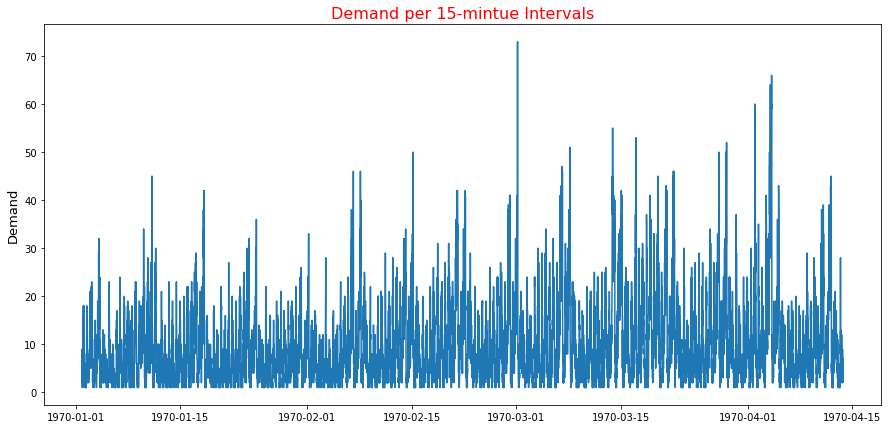

In [18]:
plt.figure(figsize=(15,7))
plt.plot(demand.index, demand)
plt.title('Demand per 15-mintue Intervals', size= 16, color= 'red')
plt.ylabel('Demand', size= 13)
plt.show()

## Handling outliers

#### 1) Make the time seris smoother
* #### Let's calculate the percent change over a rolling window by calculating the percent change of the latest data point from the mean of a window of previous data points. 
* #### Converting the data to % change over time makes easier to spot and correct the outliers.

#### 2) Replace outliers with median
* #### Outliers are data points that are so different from the rest of the data.


In [19]:
def pct_change(ts):
    """calculate percentage change over each window"""
    # separate the last value of window, from its other values
    previous_val = ts[:-1]
    last_value = ts[-1]
   
    pct_change = (last_value - np.mean(previous_val)) / np.mean(previous_val)
    return pct_change

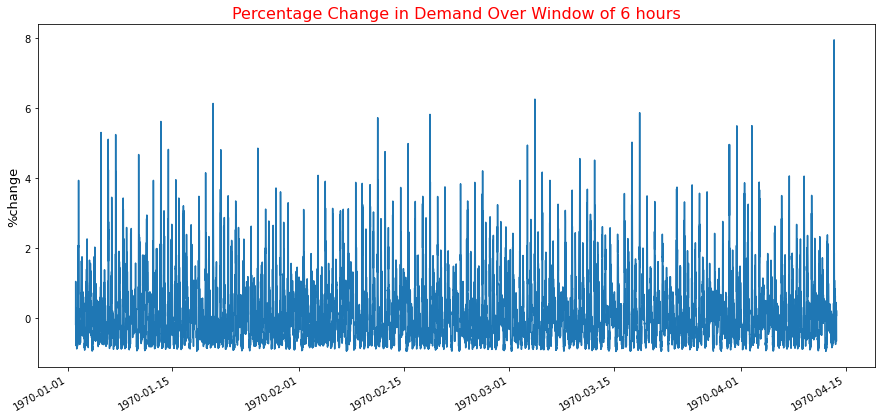

In [20]:
#calculate the percent change over a rolling window of 24 (6 hours contain 24 intervals)
demand_pct_change = demand.rolling(window= 24).apply(pct_change)

plt.figure(figsize=(15,7))
demand_pct_change.plot()
plt.title('Percentage Change in Demand Over Window of 6 hours', fontsize= 16, c='red')
plt.ylabel('%change', fontsize= 13)
plt.xlabel('')
plt.show()

In [21]:
#replace outliers with median
def replace_outliers(ts):
    mean_ts = np.mean(ts)
    std_ts = np.std(ts)
    bool_mask = (ts < mean_ts - 3*std_ts) | (ts > mean_ts + 3*std_ts)
    ts[bool_mask] = np.median(ts)
    return ts

In [22]:
demand_pct_change = replace_outliers(demand_pct_change)
demand_pct_change.dropna().head()

start_intrval
1970-01-02 02:00:00   -0.186869
1970-01-02 02:15:00    1.039409
1970-01-02 02:30:00    0.283721
1970-01-02 02:45:00   -0.366972
1970-01-02 03:00:00    0.271889
Name: demand, dtype: float64

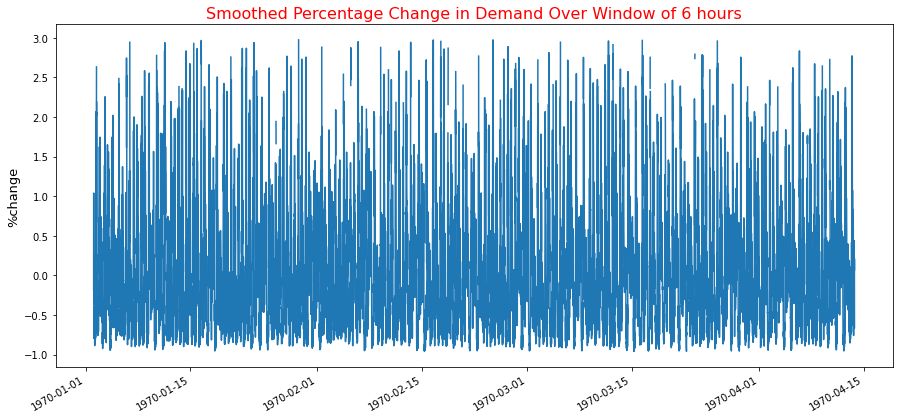

In [23]:
plt.figure(figsize=(15,7))
demand_pct_change.plot()
plt.title('Smoothed Percentage Change in Demand Over Window of 6 hours', fontsize= 16, c='red')
plt.ylabel('%change', fontsize= 13)
plt.xlabel('')
plt.show()

**Smoothness and Auto-correlation:**
It's important to consider how "smooth" data is when fitting models with timeseries. 
The smoothness of data reflects how much correlation there is between one time point and those that come before and after it. 
The extent to which previous time points are predictive of subsequent timepoints is often described as "autocorrelation", and can have a big impact on the performance of the model.

When **previous timepoints are used as input features** to the models such as Regression models, they will assign a "weight" to each input feature, and the weights determine how "smooth" or "autocorrelated" the signal is.

## Feature extraction using percentile function

**Percentiles and Quartiles:**

**A percentile** is a measure at which that percentage of the total values are the same as or below that measure. 

**Quartiles** are values that divide a (part of a) data table into four groups containing an approximately equal number of observations. The total of 100% is split into four equal parts: 25%, 50%, 75% and 100%.




In [36]:
from functools import partial

percentiles = [1, 10, 25, 50, 75, 90, 99]
#create a list of functions using a list funciton
percentile_functions = [partial(np.percentile, q= percentile) for percentile in percentiles]

#calculate quantile for each rolling window with close on right, and minimum number of observations of 6
demand_pct_change_rolling = demand_pct_change.rolling(24, min_periods= 6, closed= 'right')
features_percentiles = demand_pct_change_rolling.agg(percentile_functions)
features_percentiles.columns = ['percentile_1%', 'percentile_10%', 'percentile_25%', 'percentile_50%', 'percentile_75%'\
                               , 'percentile_90%', 'percentile_99%']
features_percentiles.dropna().head()

,percentile_1%,percentile_10%,percentile_25%,percentile_50%,percentile_75%,percentile_90%,percentile_99%
start_intrval,,,,,,,
1970-01-02 08:15:00,-0.88549,-0.857547,-0.799698,-0.511499,-0.389234,0.134262,0.865601
1970-01-02 08:30:00,-0.88549,-0.857547,-0.799698,-0.511499,-0.389234,0.095273,0.865601
1970-01-02 08:45:00,-0.88549,-0.857547,-0.799698,-0.544454,-0.396719,-0.331874,0.281000
1970-01-02 09:00:00,-0.88549,-0.857547,-0.799698,-0.544454,-0.396719,-0.331874,0.190955
1970-01-02 09:15:00,-0.88549,-0.857547,-0.799698,-0.624315,-0.459073,-0.333600,0.190955


<Figure size 1296x504 with 0 Axes>

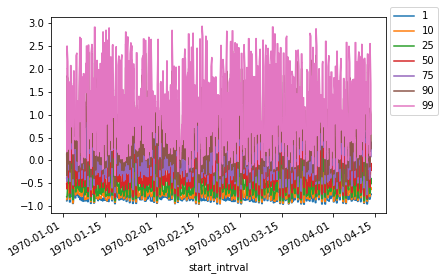

In [25]:
features_percentiles = features_percentiles.dropna()

plt.figure(figsize= (18,7))
features_percentiles.plot( )
plt.title('')
plt.legend(percentiles , loc=(1.01, .5))
plt.show()

### Creating time-lagged features

In [26]:
def shift_forward(ts, number_shift):
    #create a list of time lages
    shifts = np.arange(1,number_shift+1).astype(int)

    #create a dictionary of number of interval shift as key and shifted data as values
    shifted_ts = {'lag_{}'.format(interval_shift) :  ts.shift(interval_shift) for interval_shift in shifts}
    
    return pd.DataFrame(shifted_ts)


In [27]:
demand_pct_change_shifted = shift_forward(demand_pct_change, 6)
demand_pct_change_shifted.dropna().head(7)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
start_intrval,,,,,,
1970-01-02 03:30:00,-0.495614,0.271889,-0.366972,0.283721,1.039409,-0.186869
1970-01-02 03:45:00,-0.397380,-0.495614,0.271889,-0.366972,0.283721,1.039409
1970-01-02 04:00:00,-0.502165,-0.397380,-0.495614,0.271889,-0.366972,0.283721
1970-01-02 04:30:00,-0.797357,-0.502165,-0.397380,-0.495614,0.271889,-0.366972
1970-01-02 04:45:00,-0.479638,-0.797357,-0.502165,-0.397380,-0.495614,0.271889
1970-01-02 05:00:00,-0.795556,-0.479638,-0.797357,-0.502165,-0.397380,-0.495614
1970-01-02 05:15:00,-0.486607,-0.795556,-0.479638,-0.797357,-0.502165,-0.397380


### Regression model
* #### where the input features are time-shifted versions of the output time series data, it is Auto Regressive model. 
* #### In fact, previous values of a percentage change in demand are used to predict current values of the percentage change in demand. 

In [28]:
#fit a ridge model
from sklearn.linear_model import Ridge

# fill the missing values with the median of their column
X = demand_pct_change_shifted.fillna(np.nanmedian(demand_pct_change_shifted))
y = demand_pct_change.fillna(np.nanmedian(demand_pct_change))


ridge = Ridge()
ridge.fit(X , y)



Ridge()

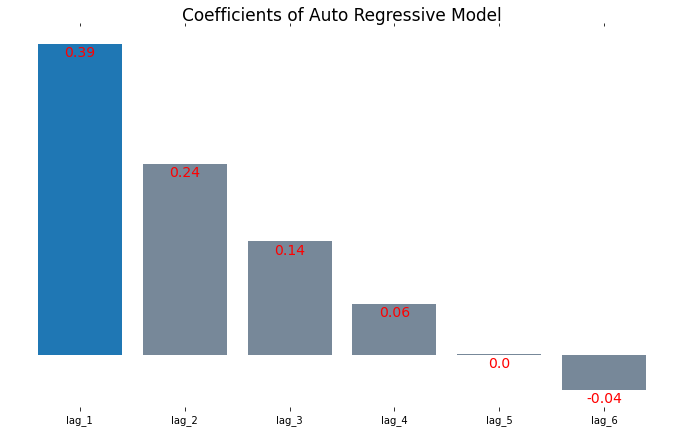

In [29]:
plt.figure(figsize=(12,7))
# change the bar color to be less bright blue
bars=plt.bar(demand_pct_change_shifted.columns, ridge.coef_, align='center', linewidth=0,  color='lightslategrey')

# make one bar, the python bar, a contrasting color
bars[0].set_color('#1F77B4')

for spine in plt.gca().spines.values():
    spine.set_visible (False)

plt.tick_params (top='off', bottom='off', left=False , right=False, labelleft=False, labelbottom='on')

#direct label each bar with Y axis values
for bar in bars:
    plt.gca().text( bar.get_x() + bar.get_width()/2 , bar.get_height()-0.016,
                   bar.get_height().round(2), ha='center', color='red', fontsize=14) 
    
plt.title('Coefficients of Auto Regressive Model', fontsize=17)    
plt.show()


* ### Percentage change in demand(demand_pct_change) is a more smooth time series. There is more "structure" to the data, which means data is not independently and identically distributed(iid). That is the reason,the coefficients for time lags drop off to zero smoothly.
* ### Lag 1, lag2 and lag3 are most important features, in other words number of demands in 15 minutes, 30 minutes and 45 minutes before mostly effect the demand in current 15 minute interval.

## Time Series Cross Validation Iterator
* #### Percentage change demand time series is not and indepednet and identically distributed data,so I cannot use CV iterator which allows randomly shuffle,
* #### I need to use training data from past to predict the future, so the training data always needs to come before validation data,
* #### In each time series cv iteration, size of the training set increases, 

### Stationarity and Stability
*  A time series is not stationary if its mean, variance and trend change over the time. I need to find **statistic relationship** between predictors and dependent variable for prediction. If time series is not stationary, it means that the relationship between predictiors and denpendent variable might be change.
* #### CV to quantify the model's parameter(s) stability.
If a model's coefficients vary widely in each cv iteration, it is the sign of non-stationary data.

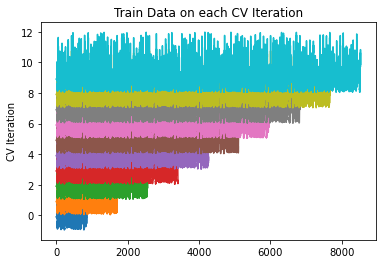

In [30]:
from sklearn.model_selection import TimeSeriesSplit

#Instantiate a time series cv object
cv = TimeSeriesSplit(n_splits=10)

#Iterate through CV splits
fig, ax = plt.subplots()
for i , (train, test) in enumerate(cv.split(X,y)):
    #plot training data on each iteration 
    ax.plot(train, i+y[train])
ax.set_title('Train Data on each CV Iteration')    
ax.set_ylabel('CV Iteration')
plt.show()
    

In [31]:

def cv_ts(model, X, y, n):
    #create an array to store coefficients in each CV iteration
    coef = np.zeros([n , X.shape[1]])  

    #Instantiate a time series cv object
    cv = TimeSeriesSplit(n_splits= n)



    #Iterate over split method yields train/test indices
    for i, (tr, tt) in enumerate(cv.split(X, y)):
        #plot training data on each iteration 
        model.fit(X.iloc[tr], y.iloc[tr])
        coef[i] = model.coef_
    return coef


### Find Bootstrapped Confidence Interval for Model's Coefficients
check variability of model's coefficients

In [32]:
from sklearn.utils import resample
a= [[1, 2, 3, 4, 5, 6],[7, 8, 9, 10, 11, 12]]

rand_sample1= resample(a)
print(rand_sample1) 
np.mean(rand_sample1, axis=0)

[[7, 8, 9, 10, 11, 12], [7, 8, 9, 10, 11, 12]]


array([ 7.,  8.,  9., 10., 11., 12.])

In [33]:
from sklearn.utils import resample

#calculate 95% confidence interval for coef of each feature
def bootstrap_CI(coef_data, percentile= [2.5, 97.5], n_boots=5):
    
    #create an array to store the mean of each bootstrap
    bs_means = np.zeros([n_boots, coef_data.shape[1]])
    
    for i in range(n_boots):   
        #random sampling from the array of coef with replacement
        rand_sample = resample(coef_data)
        bs_means[i]= rand_sample.mean(axis=0)
        
     #compute the percentiles for bootstrapped means
    percentiles = np.percentile(bs_means, percentile, axis=0)
    return percentiles 

In [34]:
# fill the missing values with the median of their column
X = demand_pct_change_shifted.fillna(np.nanmedian(demand_pct_change_shifted))
y = demand_pct_change.fillna(np.nanmedian(demand_pct_change))


cv_coef = cv_ts(Ridge(), X, y, 10)
coef_CI = bootstrap_CI(cv_coef,n_boots= 10)
print(coef_CI)

[[ 0.38327743  0.20881466  0.13866975  0.06761407  0.00454591 -0.0522075 ]
 [ 0.39154852  0.23645084  0.15332033  0.08727363  0.00922189 -0.03843584]]


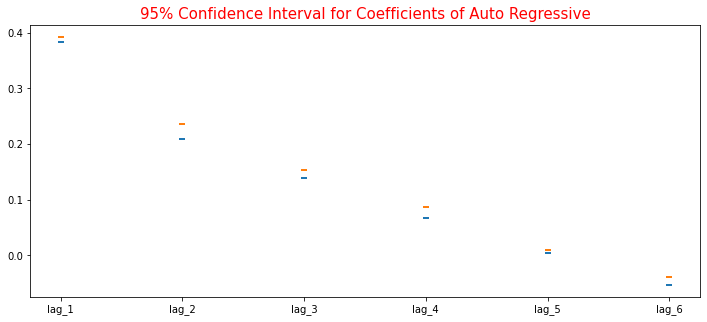

In [35]:
fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(demand_pct_change_shifted.columns, coef_CI[0], marker='_', lw= 2)
ax.scatter(demand_pct_change_shifted.columns, coef_CI[1], marker='_', lw= 2)
ax.set_title('95% Confidence Interval for Coefficients of Auto Regressive', fontsize= 15, c='red')
plt.show()


### Coefficients are stable over time.